In [1]:
import os
import h5py
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import matplotlib.gridspec as gridspec
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from IPython.display import HTML

from astropy import units as u

# Format colorbar ticks in scientific notation
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)

R_sun = 6.957e10

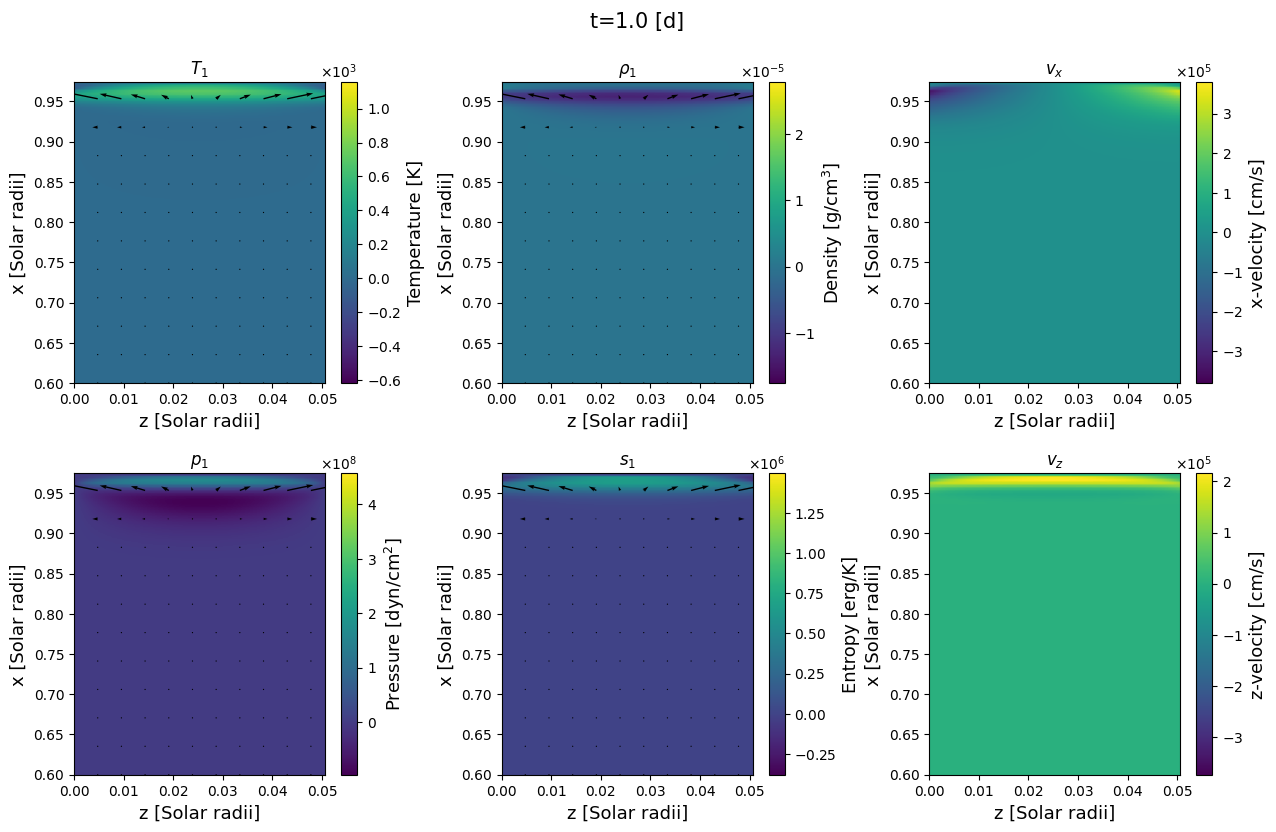

In [30]:
def read_fg(file_path):
    with h5py.File(file_path, 'r') as f:
        T1 = np.array(f['/T1'])
        rho1 = np.array(f['/rho1'])
        p1 = np.array(f['/p1'])
        s1 = np.array(f['/s1'])
        vx = np.array(f['/vx'])
        vz = np.array(f['/vz'])
        info = f['info'][0].decode("utf-8")

    return T1, rho1, p1, s1, vx, vz, info

def read_bg(file_path):
    with h5py.File(file_path, 'r') as f:
        r = np.array(f['/r'])
        T0 = np.array(f['/T0'])
        rho0 = np.array(f['/rho0'])
        p0 = np.array(f['/p0'])
        g = np.array(f['/g'])
        grad_s0 = np.array(f['/grad_s0'])
        
    return r, T0, rho0, p0, g, grad_s0

def get_info(info):
    t = eval(info.split("\n")[0].split(":")[1])
    nx = eval(info.split("\n")[1].split(":")[1])
    nz = eval(info.split("\n")[2].split(":")[1])
    nz_ghost = eval(info.split("\n")[3].split(":")[1])
    dx = eval(info.split("\n")[4].split(":")[1])
    dz = eval(info.split("\n")[5].split(":")[1])
    return t, nx, nz, nz_ghost, dx, dz

def format_title(key):
    # Dictionary for special replacements
    special = {"rho": r"\rho", "p": "p", "T": "T", "v": "v"}

    # Using the last character as the subscript
    prefix = key[:-1]
    suffix = key[-1]

    # Replace with special character if available
    prefix = special.get(prefix, prefix)

    return "${}_{}$".format(prefix, suffix)

class Visualize_Foreground:
    def __init__(self, folder):
        self.folder = folder + "snap{}.h5"
        self.num_snaps = len(os.listdir(folder))-1
        
        self.set_plot_params()
        
    def set_plot_params(self):
        self.quiver_stride = 10
        self.font_size = 13
        self.title_size = 15
        
        max_values = [0] * 6
        min_values = [0] * 6
        for i in range(self.num_snaps):
            T1, rho1, p1, s1, vx, vz, info = read_fg(self.folder.format(i))
            
            max_values = np.maximum(max_values, [T1.max(), rho1.max(), p1.max(), s1.max(), vx.max(), vz.max()])
            min_values = np.minimum(min_values, [T1.min(), rho1.min(), p1.min(), s1.min(), vx.min(), vz.min()])
        
        T1, rho1, p1, s1, vx, vz, info = read_fg(self.folder.format(self.num_snaps-1))
        t, nx, nz, nz_ghost, dx, dz = get_info(info)
        
        """
        THIS NEEDS TO BE IN THE INFO FILE
        """
        self.x_0 = 0
        self.x_1 = dx*nx/R_sun
        self.z_0 = 0.6
        self.z_1 = 0.6 + nz*dz/R_sun
        
        self.aspect = (self.x_1-self.x_0)/(self.z_1-self.z_0) * 1.2
        
        t_end = t*u.s
        if t>1e4:
            self.t_end = t_end.to("h")
        if t>1e5:
            self.t_end = t_end.to("day")
        
        self.quiver_scale = 4*max(max(max_values[4], max_values[5]), max(np.abs(min_values[4]), np.abs(min_values[5])))
        
        # holding touple(var_name, quiver true/false, vmin, vmax)
        self.plot_params = {
            "T1": (True, min_values[0], max_values[0], "Temperature [K]"),
            "rho1": (True, min_values[1], max_values[1], r"Density [g/cm$^3$]"),
            "p1": (True, min_values[2], max_values[2], r"Pressure [dyn/cm$^2$]"),
            "s1": (True, min_values[3], max_values[3], "Entropy [erg/K]"),
            "vx": (False, min_values[4], max_values[4], "x-velocity [cm/s]"),
            "vz": (False, min_values[5], max_values[5], "z-velocity [cm/s]")
        }     

    def plot(self, fig, ax, snap_nr, key):
        T1, rho1, p1, s1, vx, vz, info = read_fg(self.folder.format(snap_nr))
        d = {"T1": T1, "rho1": rho1, "p1": p1, "s1": s1, "vx":vx, "vz":vz}
        t, nx, nz, nz_ghost, dx, dz = get_info(info)
    
        d = d[key][nz_ghost:-1-nz_ghost+1,:]
        if self.plot_params[key][0]:
            vx = vx[nz_ghost:-1-nz_ghost+1,:]
            vz = vz[nz_ghost:-1-nz_ghost+1,:]

            Y, X = np.mgrid[0:d.shape[0]:self.quiver_stride, 0:d.shape[1]:self.quiver_stride]
            # Convert pixel indices to data coordinates
            X_data = (X * dx)/R_sun
            Y_data = (Y * dz)/R_sun+self.z_0
            ax.quiver(X_data, Y_data, vx[::self.quiver_stride, ::self.quiver_stride], vz[::self.quiver_stride, ::self.quiver_stride], scale=self.quiver_scale)
        
        t = t*u.s
        t = t.to(self.t_end.unit)
        
        ax.set_title(format_title(key))
        ax.set_xlabel("z [Solar radii]", fontsize=self.font_size)
        ax.set_ylabel("x [Solar radii]", fontsize=self.font_size)
        
        vmin = self.plot_params[key][1]
        vmax = self.plot_params[key][2]
        im =ax.imshow(d, origin="lower", extent=[self.x_0,self.x_1,self.z_0,self.z_1], aspect=self.aspect,vmin=vmin, vmax=vmax)
        return im, t

    def plot_all(self, fig, snap_nr):
        gs = gridspec.GridSpec(2, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], wspace=0.25, hspace=0.3)

        # Order of keys for plotting
        plot_order = ["T1", "rho1", "vx", "p1", "s1", "vz"]

        for idx, key in enumerate(plot_order):
            i, j = divmod(idx, 3)  # Convert 1D index to 2D indices
            # Create the subplot using GridSpec indexing
            ax = fig.add_subplot(gs[i, 2*j])
            
            im, t = self.plot(fig, ax, snap_nr, key)
            
            # Create a new axes for the colorbar next to the current subplot
            pos = ax.get_position()
            cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.01, pos.height])
            cbar = plt.colorbar(im, cax=cax)

            # Set label for the colorbar
            cbar.set_label(self.plot_params[key][3], fontsize=self.font_size)

            # Enforce scientific notation
            formatter = ScalarFormatter(useMathText=True)
            formatter.set_scientific(True)
            formatter.set_powerlimits((-1, 1))
            cbar.ax.yaxis.set_major_formatter(formatter)

        # Title for the entire plot with the time
        fig.suptitle(f"t={t.value:.1f} [{t.unit.to_string(format='latex_inline')}]", fontsize=self.title_size, y=0.96)

    def save_image_all(self, snap_nr, filename):
        fig = plt.figure(figsize=(16, 9))
        self.plot_all(fig, 12)
        fig.savefig(filename, dpi=80, bbox_inches='tight')
                
            
    def animate(self, save=False, save_name=None):
        pass
    

vf = Visualize_Foreground("../data/velocity_right/")

#fig = plt.figure(figsize=(16, 9))
vf.save_image_all(12, "./all_test.pdf")

#plt.show()

In [ ]:



#im, t = vf.plot(fig, ax, 10, "T1")
#fig.suptitle("t={:.2f} [{}]".format(t.value, t.unit))




In [ ]:

"""
    def plot_all(self, fig):

        # Sample data
        data = np.random.rand(10, 10)

        data_unit_scale = np.random.rand(10, 10)

        # Scale these floats by random powers of 10 in the range [-5, 5]
        powers_of_ten = np.random.randint(-5, 6, size=(10, 10))
        data = data_unit_scale * (10. ** powers_of_ten)

        # Define the gridspec
        gs = gridspec.GridSpec(2, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], wspace=0.5, hspace=0.5)

        # Sample labels and titles
        axis_titles = ["Title 1", "Title 2", "Title 3", "Title 4", "Title 5", "Title 6"]
        colorbar_labels = ["CB Label 1", "CB Label 2", "CB Label 3", "CB Label 4", "CB Label 5", "CB Label 6"]

        for i in range(2):
            for j in range(3):
                # Create the subplot using GridSpec indexing
                ax = fig.add_subplot(gs[i, 2*j])
                im = ax.imshow(data, cmap="viridis")

                # Set x and y labels for each axis
                ax.set_xlabel("X Axis Label")
                ax.set_ylabel("Y Axis Label")

                # Set title for each axis
                ax.set_title(axis_titles[3*i + j])

                # Get the position of the current subplot
                pos = ax.get_position()

                # Create a new axes for the colorbar next to the current subplot
                cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.015, pos.height])
                cbar = plt.colorbar(im, cax=cax)

                # Set label for the colorbar
                cbar.set_label(colorbar_labels[3*i + j], fontsize=13)

                formatter.set_powerlimits((-1, 1))
                cbar.ax.yaxis.set_major_formatter(formatter)


        # Title for the entire plot
        fig.suptitle("Main Title", fontsize=16, y=1.05)
"""

    def plot_all(self, fig):
        gs = gridspec.GridSpec(2, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], wspace=0.5, hspace=0.5)

        # Order of keys for plotting
        plot_order = ["T1", "rho1", "vx", "p1", "s1", "vz"]


In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12, 18))  # 3x2 grid of subplots

colorbars = [[None for _ in range(3)] for _ in range(2)]  # 3x2 grid of colorbars

# List of tuples containing the data string, quivers boolean, vmax, and vmin
plot_params = [
    ("vx", False, -3e5, 3e5),      # example vmax and vmin
    ("vz", False, 0, 1.75e5),
    ("p1", True, 0, 2e8),
    ("s1", True, -3e5, 1e6),
    ("T1", True, -400, 1500),  # assuming temperature in Kelvin
    ("rho1", True, -2e5, -1e-5)     # example density vmax and vmin
]

def init():
    for idx, (param, quiver, vmax, vmin) in enumerate(plot_params):
        i, j = divmod(idx, 3)  # Convert 1D index to 2D indices for 2x3 grid
        im = plot(axs[i, j], fig, 0, param, stride, scale, quivers=quiver, vmax=vmax, vmin=vmin, path=path)
        
        # Create colorbar axis right next to the plot
        cax = fig.add_axes([axs[i, j].get_position().x1+0.01, 
                            axs[i, j].get_position().y0, 
                            0.02, 
                            axs[i, j].get_position().height])
        colorbars[i][j] = plt.colorbar(im, cax=cax)

def animate(frame):
    for idx, (param, quiver, vmin, vmax) in enumerate(plot_params):
        i, j = divmod(idx, 3)
        if colorbars[i][j] is not None:
            colorbars[i][j].remove()
        axs[i, j].clear()
        im = plot(axs[i, j], fig, frame, param, stride, scale, quivers=quiver, vmax=vmax, vmin=vmin, path=path)
        
        # Create colorbar axis right next to the plot
        cax = fig.add_axes([axs[i, j].get_position().x1+0.01, 
                            axs[i, j].get_position().y0, 
                            0.02, 
                            axs[i, j].get_position().height])
        colorbars[i][j] = plt.colorbar(im, cax=cax)


fig.tight_layout()
fig.subplots_adjust(wspace=1)  # Adjust this value as needed


anim = FuncAnimation(fig, animate, interval=250, frames=range(5), init_func=init)
#HTML(anim.to_jshtml())
anim.save('test.mp4', writer='ffmpeg', fps=4, extra_args=['-vcodec', 'libx264'])

In [ ]:
vf = Visualize_Foreground("../data/velocity_right/", )

fig, ax = plt.subplots()

im, t = vf.plot(fig, ax, 10, "T1")
fig.suptitle("t={:.2f} [{}]".format(t.value, t.unit))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Sample data
data = np.random.rand(10, 10)

data_unit_scale = np.random.rand(10, 10)

# Scale these floats by random powers of 10 in the range [-5, 5]
powers_of_ten = np.random.randint(-5, 6, size=(10, 10))
data = data_unit_scale * (10. ** powers_of_ten)
fig = plt.figure(figsize=(16, 8))

# Define the gridspec
gs = gridspec.GridSpec(2, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], wspace=0.5, hspace=0.5)

# Sample labels and titles
axis_titles = ["Title 1", "Title 2", "Title 3", "Title 4", "Title 5", "Title 6"]
colorbar_labels = ["CB Label 1", "CB Label 2", "CB Label 3", "CB Label 4", "CB Label 5", "CB Label 6"]

for i in range(2):
    for j in range(3):
        # Create the subplot using GridSpec indexing
        ax = fig.add_subplot(gs[i, 2*j])
        im = ax.imshow(data, cmap="viridis")
        
        # Set x and y labels for each axis
        ax.set_xlabel("X Axis Label")
        ax.set_ylabel("Y Axis Label")
        
        # Set title for each axis
        ax.set_title(axis_titles[3*i + j])
        
        # Get the position of the current subplot
        pos = ax.get_position()
        
        # Create a new axes for the colorbar next to the current subplot
        cax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.015, pos.height])
        cbar = plt.colorbar(im, cax=cax)
        
        # Set label for the colorbar
        cbar.set_label(colorbar_labels[3*i + j])
        
        formatter.set_powerlimits((-1, 1))
        cbar.ax.yaxis.set_major_formatter(formatter)


# Title for the entire plot
fig.suptitle("Main Title", fontsize=16, y=1.05)
#plt.tight_layout()
plt.show()


In [ ]:
"""
    def plot(ax, fig, index, key, stride=1, scale=0.01, quivers=True, vmin=None, vmax=None, path=None):

        T1, rho1, p1, s1, vx, vz, info = read_fg(self.folder+"snap{}.h5".format(index))
        d = {"T1": T1, "rho1": rho1, "p1": p1, "s1": s1, "vx":vx, "vz":vz}
    
    t, nx, nz, nz_ghost, dx, dz = get_info(info)
    
    x_extent = dx*nx/R_sun

    z_0 = 0.6
    z_1 = nz*dz/R_sun + 0.6

    z_extent = (z_1 - z_0)

    aspect = x_extent/z_extent * 1.2
    
    d = d[key][nz_ghost:-1-nz_ghost+1,:]
    if quivers:
        vx = vx[nz_ghost:-1-nz_ghost+1,:]
        vz = vz[nz_ghost:-1-nz_ghost+1,:]

        height, width = d.shape
        Y, X = np.mgrid[0:height:stride, 0:width:stride]
        # Convert pixel indices to data coordinates
        X_data = (X * dx)/R_sun
        Y_data = (Y * dz)/R_sun+0.6  # Adding z_0 to start from the right location in the z-direction
        #print(Y_data)
        ax.quiver(X_data, Y_data, vx[::stride, ::stride], vz[::stride, ::stride], scale=scale)

    ax.set_title("{:}, t={:.1f} [ks]".format(key, t/1e3))
    ax.set_xlabel("z [Solar radii]")
    ax.set_ylabel("x [Solar radii]")
    
    im =ax.imshow(d, origin="lower", extent=[0,x_extent,z_0,z_1], aspect=aspect,vmin=vmin, vmax=vmax)
    #im =ax.imshow(d, origin="lower", extent=[0,x_extent,z_0,z_1], aspect=aspect)
    
    ax.set_xlim(0, x_extent)
    ax.set_ylim(z_0, z_1)
    return im
"""

In [ ]:
with h5py.File("../data/HD_2D_1/snap0.h5", 'r') as f:
    info_byte_string = f['info'][0]
    info_string = info_byte_string.decode("utf-8")
    print(info_string)

In [ ]:


r_, T0_, rho0_, p0, g_, grad_s0_\
    =read_solar_S_hdf5("../data/HD_2D_1/background.h5")

In [ ]:
T1, rho1, p1_old, s1, vx, vz, info = read_fg("../data/HD_2D_1/snap0.h5")

In [ ]:
np.where((p1 + p0[:, np.newaxis]) < 0)

In [ ]:
nz * dz/R_sun

In [ ]:
np.max(np.abs(p1-p1_old))/np.max(p1_old)

In [ ]:
(dz * p1_no_ghost.shape[0])/R_sun

In [ ]:
aspect

In [ ]:
T1, rho1, p1, s1, vx, vz, info = read_fg("../data/HD_2D_1/snap2.h5")

In [ ]:
len(np.where(p1_no_ghost<=0)[0])

In [ ]:
p1_no_ghost.shape

In [ ]:
100 * 60 * 60

In [ ]:
nz_ghost = eval(info.split("\n")[3].split(":")[1])
nz = eval(info.split("\n")[2].split(":")[1])
nx = eval(info.split("\n")[1].split(":")[1])
t = eval(info.split("\n")[0].split(":")[1])
dx = eval(info.split("\n")[4].split(":")[1])
dz = eval(info.split("\n")[5].split(":")[1])

fig, ax = plt.subplots()

R_sun = 6.957e10

p1_no_ghost = p1[nz_ghost:-1-nz_ghost+1,:]
x_extent = dx*nx/R_sun

z_0 = 0.6
z_1 = nz*dz/R_sun + 0.6

z_extent = (z_1 - z_0) * 0.8

aspect = x_extent/z_extent

im = ax.imshow(p1_no_ghost, origin="lower", extent=[0, x_extent, z_0, z_1], aspect=aspect)
colorbar = plt.colorbar(im, ax=ax)
ax.set_title("p1")
ax.set_xlabel("z [Solar radii]")
ax.set_ylabel("x [Solar radii]")

In [ ]:

tt = 0.7e9 * u.s
tt.to("year")

In [ ]:


def plot(ax, fig, index, key, stride=1, scale=0.01, quivers=True, vmin=None, vmax=None, path=None):
    file_path = path+"snap{}.h5".format(index)
    
    T1, rho1, p1, s1, vx, vz, info = read_fg(file_path)
    d = {"T1": T1, "rho1": rho1, "p1": p1, "s1": s1, "vx":vx, "vz":vz}
    
    t, nx, nz, nz_ghost, dx, dz = get_info(info)
    
    x_extent = dx*nx/R_sun

    z_0 = 0.6
    z_1 = nz*dz/R_sun + 0.6

    z_extent = (z_1 - z_0)

    aspect = x_extent/z_extent * 1.2
    
    d = d[key][nz_ghost:-1-nz_ghost+1,:]
    if quivers:
        vx = vx[nz_ghost:-1-nz_ghost+1,:]
        vz = vz[nz_ghost:-1-nz_ghost+1,:]

        height, width = d.shape
        Y, X = np.mgrid[0:height:stride, 0:width:stride]
        # Convert pixel indices to data coordinates
        X_data = (X * dx)/R_sun
        Y_data = (Y * dz)/R_sun+0.6  # Adding z_0 to start from the right location in the z-direction
        #print(Y_data)
        ax.quiver(X_data, Y_data, vx[::stride, ::stride], vz[::stride, ::stride], scale=scale)

    ax.set_title("{:}, t={:.1f} [ks]".format(key, t/1e3))
    ax.set_xlabel("z [Solar radii]")
    ax.set_ylabel("x [Solar radii]")
    
    im =ax.imshow(d, origin="lower", extent=[0,x_extent,z_0,z_1], aspect=aspect,vmin=vmin, vmax=vmax)
    #im =ax.imshow(d, origin="lower", extent=[0,x_extent,z_0,z_1], aspect=aspect)
    
    #ax.set_xlim(0, x_extent)
    #ax.set_ylim(z_0, z_1)
    return im

#path = "../data/HD_2D_1/"
path = "../data/velocity_right/"


num_snaps = len(os.listdir(path))-1
T1, rho1, p1, s1, vx, vz, info = read_fg(path+"snap{}.h5".format(int(3)))


stride = 10
scale = max(np.max(vx),np.max(vz)) * 2

fig, axs = plt.subplots(3, 2, figsize=(12, 18))  # 3x2 grid of subplots

colorbars = [[None for _ in range(2)] for _ in range(3)]  # 3x2 grid of colorbars

# List of tuples containing the data string, quivers boolean, vmax, and vmin
plot_params = [
    ("vx", False, -3e5, 3e5),      # example vmax and vmin
    ("vz", False, 0, 1.75e5),
    ("p1", True, 0, 2e8),
    ("s1", True, -3e5, 1e6),
    ("T1", True, -400, 1500),  # assuming temperature in Kelvin
    ("rho1", True, -2e5, -1e-5)     # example density vmax and vmin
]

def init():
    for idx, (param, quiver, vmax, vmin) in enumerate(plot_params):
        i, j = divmod(idx, 2)  # Convert 1D index to 2D indices
        im = plot(axs[i, j], fig, 0, param, stride, scale, quivers=quiver, vmax=vmax, vmin=vmin,path=path) # set vmax and vmin here
        colorbars[i][j] = plt.colorbar(im, ax=axs[i, j])

def animate(frame):
    for idx, (param, quiver, vmin, vmax) in enumerate(plot_params):
        i, j = divmod(idx, 2)
        if colorbars[i][j] is not None:
            colorbars[i][j].remove()
        axs[i, j].clear()
        im = plot(axs[i, j], fig, frame, param, stride, scale, quivers=quiver, vmax=vmax, vmin=vmin,path=path) # set vmax and vmin here
        colorbars[i][j] = plt.colorbar(im, ax=axs[i, j])

fig.tight_layout()


anim = FuncAnimation(fig, animate, interval=250, frames=range(5), init_func=init)
HTML(anim.to_jshtml())
#anim.save('velocity_right.mp4', writer='ffmpeg', fps=4, extra_args=['-vcodec', 'libx264'])

In [ ]:
T1, rho1, p1, s1, vx, vz =read_fg("../data/HD_2D_1/snap2.h5")

fig,ax = plt.subplots(figsize=(6,6))

ax.imshow(vx)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

def animate_snap(base_filename, var_name, snap_range, pause_duration=0.5):
    """
    Animate the specified variable from the HDF5 snapshots.

    base_filename: Base path to the snap files. Should contain a '{}' placeholder for the snap number.
    var_name: Variable name, e.g. 'T1', 'rho1', etc.
    snap_range: Range of snap numbers to animate.
    pause_duration: Time (in seconds) to display each snap before moving on.
    """
    
    fig, ax = plt.subplots()

    for i in snap_range:
        # Clear previous images and colorbars
        ax.clear()

        filename = base_filename.format(i)
        data = read_fg(filename)
        var_dict = {'T1': 0, 'rho1': 1, 'p1': 2, 's1': 3, 'vx': 4, 'vz': 5}
        var_idx = var_dict[var_name]
        
        im = ax.imshow(data[var_idx], aspect='auto')
        ax.set_title(f"{var_name} - snap{i}")

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label(var_name)  # set the label of the colorbar to the variable name
        
        plt.draw()
        display(fig)
        clear_output(wait=True)
        time.sleep(pause_duration)

    plt.close() # close the figure at the end to avoid duplication


animate_snap("../data/HD_2D_1/snap{}.h5", "T1", range(0,5))

In [ ]:
T1, rho1, p1, s1, vx, vz =read_fg("../data/HD_2D_1/snap5.h5")

fig,ax = plt.subplots(figsize=(6,6))

ax.imshow(T1)

In [ ]:
p1